In [72]:
import numpy as np
import matplotlib.pyplot as plt

from random import uniform

FIDELITY = 350
TRACK_WIDTH = 3.5


def get_normal_vector(vec):
        """Given a vector, return a vector normal to it"""
        return (-vec[1], vec[0])

def calculate_tangent_angle(xys):
        """
        Calculate direction of outgoing tangent of a set of points
        Is an angle!
        """
        sx = xys[-2][0]
        sy = xys[-2][1]
        ex = xys[-1][0]
        ey = xys[-1][1]
        return np.arctan2((ey - sy), (ex - sx))

def calculate_tangent_vector(xys):
        angle = calculate_tangent_angle(xys)
        return (np.cos(angle), np.sin(angle))

def add_vectors(a, b):
        """Given two tuples a and b, add them together"""
        return (a[0] + b[0], a[1] + b[1])


def scale_vector(vec, scale):
        """Multiplies vec by scale"""
        return (vec[0] * scale, vec[1] * scale)


def de_parameterize(func):
        """Given a parametric function, turn it into a list of points"""
        return [func(1.0 * t / (FIDELITY - 1))
                for t in range(0, FIDELITY)]


def parametric_straight(slope_vec, start_point, line_length):
        """Returns the parametric function of a line given a slope and start point"""
        def to_return(slope, start, length, t):
                return add_vectors(start, scale_vector(slope, 1.0 * t * line_length))
        return Parametrization(lambda t: to_return(slope_vec, start_point, line_length, t))


def parametric_circle(start_point, center_point, delta_angle):
        """
        Returns a function in terms of t \elem [0,1] to parameterize a circle

        We can calculate points on a circle using a rotation matrix
        R(a)*[S-C]+C gives us any point on a circle starting at S with center C
        with counterclockwise angular dstance 'a'
        """
        def output(s, c, a):
                (sx, sy) = s
                (cx, cy) = c
                cos_a = np.cos(a)
                sin_a = np.sin(a)
                del_x = sx - cx
                del_y = sy - cy
                result_x = cos_a * del_x - sin_a * del_y + cx
                result_y = sin_a * del_x + cos_a * del_y + cy
                
                return (result_x, result_y)
        return Parametrization(lambda t: output(start_point, center_point, t * delta_angle))

def plot_trackLine(data):
        a = np.empty(len(data))
        b = np.empty(len(data))
        for i in range(len(data)):
                a[i] = data[i][0]
                b[i] = data[i][1]
        plt.plot(a,b)
        plt.show()

class Parametrization:
        """
        Class that is used to seemlessly store and combine parametrization functions
        for the generator.

        Parametrization functions are defined as functions which take a number \elem [0,1]
        and return a point.  It is used to define geometric curves in terms of a percentage.
        So if you had a circle parametrization function, and gave it an input 0.25, it would
        return the point 25% of the way around the circle segment.
        """
        def __init__(self, func):
                self._func = func

        def __call__(self, num):
                return self._func(num)

        @staticmethod
        def compose(others):
                """
                Combines two parametrizations in a way such that the composite
                still only takes a number from 0 to 1.
                """
                amount = len(others)
                threshold = 1.0/amount

                def composite(num):
                        # Check out of bounds
                        if num <= 0:
                                return others[0](0)
                        elif num >= 1:
                                return others[-1](1)

                        # Acts as composition of components
                        i = 0
                        while True:
                                if num < threshold:
                                        return others[i](amount * num)
                                else:
                                        num -= threshold
                                        i += 1
                return Parametrization(composite)

class CONE_INNER:
    pass


class CONE_OUTER:
    pass


class CONE_ORANGE:
    pass


class CONE_START:
    pass


class CONE_BIG_ORANGE:
    pass


def cone_default(xys, starting=False, track_width=None, slalom=False, prev_points=None):
        """
        Default cone placement algorithm, can be overriden on a micro by using the
        special micro decorator.

        Takes in a list of points, returns a list of triples dictating x, y position
        of cone of color color [(x, y, color)].

        Optionally takes a flag "starting" to make the first pair of cones orange,
        and optional "track_width" to override TrackGenerator.TRACK_WIDTH, which
        is useful if accessing ConversionTools.xys_to_png from a non-generator context.
        """

        if track_width is None:
                cone_normal_distance_parameter = TRACK_WIDTH
        else:
                cone_normal_distance_parameter = track_width

        # Hardcoded parameters (not available in launcher because the set of
        # well-behaved answers is far from dense in the problemspace):

        # How close can cones be from those on opposite side.
        cone_cross_closeness_parameter = cone_normal_distance_parameter * 3 / 4 - 1
        print("cone_cross_closeness_parameter"+str(cone_cross_closeness_parameter))

        # Larger numbers makes us check more parts of the track for conflicts.
        cone_check_amount = 30

        # How close can cones be from those on the same side.
        cone_adjacent_closeness_parameter = 4

        all_points_north = []
        all_points_south = []
        prev_points_north = [(-10000, -10000)]
        prev_points_south = [(-10000, -10000)]
        to_return = []

        # Process the previous points down to a manageable amount.
        # if prev_points is not None:
        #         first_orange_cones = [
        #                 (x, y) for x, y, c in prev_points
        #                 if c is CONE_ORANGE
        #         ][:2]
        #         all_points_south = [
        #                 (x, y) for x, y, c in prev_points
        #                 if c is CONE_INNER
        #         ]
        #         all_points_south = (
        #                 all_points_south[-cone_check_amount:] + first_orange_cones
        #         )
        #         all_points_north = [
        #                 (x, y) for x, y, c in prev_points
        #                 if c is 
        

        #         ]
        #         all_points_north = (
        #                 all_points_north[-cone_check_amount:] + first_orange_cones
        #         )

        # This is used to check if the yellow and blue cones suddenly swapped.
        last_tangent_normal = (0, 0)

        # Used to make sure orange cones start ahead of the car
        orig_tangent = (0, 0)

        for i in range(len(xys)):
                # Skip first part [as hard to calculate tangent]
                if i == 0:
                    continue

                # The idea here is to place cones along normals to the
                # tangent at any given point,
                # while making sure they aren't too close.

                # Here we calculate the normal vectors along the track
                # As we want cones to be placed along the normal.
                cur_point = xys[i]
                cur_tangent_angle = calculate_tangent_angle(xys[:(i+1)])
                if i == 1:
                    orig_tangent = (np.cos(cur_tangent_angle), np.sin(cur_tangent_angle))
                cur_tangent_normal = (
                    np.ceil(
                        cone_normal_distance_parameter * np.sin(cur_tangent_angle)
                    ),
                    np.ceil(
                        -cone_normal_distance_parameter * np.cos(cur_tangent_angle)
                    )
                )

                # Check if normal direction suddenly flipped relative to last iteration.
                # (And reverse it if it happened)
                dot_product = (
                        last_tangent_normal[0] * cur_tangent_normal[0] +
                        last_tangent_normal[1] * cur_tangent_normal[1]
                )

                # Tangent flipped!
                # (As when dot product is negative, vectors are opposite)
                if dot_product < 0:
                        cur_tangent_normal = scale_vector(cur_tangent_normal, -1)

                last_tangent_normal = cur_tangent_normal

                # This is where the cones will be placed, provided they pass the
                # distance checks later.
                north_point = ((cur_point[0] + cur_tangent_normal[0]),
                               (cur_point[1] + cur_tangent_normal[1]))
                south_point = ((cur_point[0] - cur_tangent_normal[0]),
                               (cur_point[1] - cur_tangent_normal[1]))

                # Calculates shortest distance to cone on same side of track
                difference_from_prev_north = min([
                                                  (north_point[0] - prev_point_north[0])**2 +
                                                  (north_point[1] - prev_point_north[1])**2
                                                  for prev_point_north in prev_points_north
                ])
                difference_from_prev_south = min([
                                                  (south_point[0] - prev_point_south[0])**2 +
                                                  (south_point[1] - prev_point_south[1])**2
                                                  for prev_point_south in prev_points_south
                ])

                # Calculates shortest distance to cone on different side of track
                cross_distance_ns = min([
                                         (north_point[0] - prev_point_south[0])**2 +
                                         (north_point[1] - prev_point_south[1])**2
                                         for prev_point_south in prev_points_south
                ])
                cross_distance_sn = min([
                                         (south_point[0] - prev_point_north[0])**2 +
                                         (south_point[1] - prev_point_north[1])**2
                                         for prev_point_north in prev_points_north
                ])

                # Here we ensure cones don't get too close to the track
                rel_xys = xys[
                    max([0, i - cone_check_amount]):
                    min([len(xys), i + cone_check_amount])
                ]
                distance_pn = min([
                                   (north_point[0] - xy[0])**2 +
                                   (north_point[1] - xy[1])**2
                                   for xy in rel_xys
                ])
                distance_ps = min([
                                   (south_point[0] - xy[0])**2 +
                                   (south_point[1] - xy[1])**2
                                   for xy in rel_xys
                ])

                # And we consider all these factors to see if the cones are viable
                north_viable = (
                      difference_from_prev_north > cone_adjacent_closeness_parameter**2 and
                      cross_distance_ns > cone_cross_closeness_parameter**2 #and
                      #distance_pn > cone_cross_closeness_parameter**2
                )
                south_viable = (
                                difference_from_prev_south > cone_adjacent_closeness_parameter**2 and
                                cross_distance_sn > cone_cross_closeness_parameter**2 #and
                                #distance_ps > cone_cross_closeness_parameter**2
                )

                # And when they are viable, draw them!
                if (north_viable):
                        px_x = (north_point[0])
                        px_y = (north_point[1])
                        to_return.append((px_x, px_y, CONE_OUTER))
                        all_points_north.append(north_point)
                if (south_viable):
                        px_x = (south_point[0])
                        px_y = (south_point[1])
                        to_return.append((px_x, px_y, CONE_INNER))
                        all_points_south.append(south_point)

                # Handle placement of slalom cones
                if slalom and (north_viable or south_viable):
                        to_return.append(((cur_point[0]), (cur_point[1]), CONE_ORANGE))

                # Only keep track of last couple of previous cones
                # (and the very fionerst , for when the loop joins up)
                # Specifically, if we assume cone_check_amount is 30, then
                # we have prev_points north keep track of the most recent 30 cones,
                # and also the very first start cone.
                # This is because we want to make sure no cones are too close to eachother,
                # but checking all cones would be too expensive.
                # The first cone is kept track of because the track is a loop so
                # it needs to look ahead a bit.
                if len(all_points_north) > cone_check_amount:
                        prev_points_north = (all_points_north[-cone_check_amount:] + [all_points_north[0]])
                elif len(all_points_north) > 0:
                        prev_points_north = all_points_north

                if len(all_points_south) > cone_check_amount:
                        prev_points_south = (all_points_south[-cone_check_amount:] + [all_points_south[0]])
                elif len(all_points_south) > 0:
                        prev_points_south = all_points_south

        
        return to_return

def cone_rec():
        cone_normal_distance_parameter = TRACK_WIDTH
        

cone_cross_closeness_parameter1.625
[(1.0900166775565554, -2.999797423918114, <class '__main__.CONE_OUTER'>), (-0.9099833224434445, 3.000202576081886, <class '__main__.CONE_INNER'>), (5.11126193751539, -2.5728772867235143, <class '__main__.CONE_OUTER'>), (3.1112619375153896, 3.4271227132764857, <class '__main__.CONE_INNER'>), (9.04675608216915, -1.717457859399925, <class '__main__.CONE_OUTER'>), (6.78180354574933, 5.031140089480786, <class '__main__.CONE_INNER'>), (12.361566799589497, 0.8933365772969992, <class '__main__.CONE_OUTER'>), (15.916944264141197, 2.7306663250464727, <class '__main__.CONE_OUTER'>), (10.257269394806892, 7.025194218504318, <class '__main__.CONE_INNER'>), (18.724433722411334, 5.641109106821386, <class '__main__.CONE_OUTER'>), (12.998556178898216, 9.998075146434314, <class '__main__.CONE_INNER'>), (21.199240783073357, 8.792839940224994, <class '__main__.CONE_OUTER'>), (14.620605347729445, 13.701160607047889, <class '__main__.CONE_INNER'>), (22.900908370343295, 12.

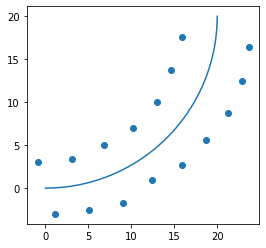

In [73]:
# for i in range(100):
#     #print(parametric_circle([0,0],[1,1],np.pi)(i/100))
#     print(
#         de_parameterize(parametric_circle([0,0],[1,1],np.pi))
#     )
#     #list.append(parametric_circle([0,0],[1,1],np.pi)(i/100))
d=1#left turn=> negative for right turn
data=list(de_parameterize(parametric_circle([0,0],[0,d*20],d*np.pi/2)))

x = np.empty(len(data))
y = np.empty(len(data))
for i in range(len(data)):
        x[i] = data[i][0]
        y[i] = data[i][1]
plt.plot(x,y)

#plot_trackLine(data)
conedata=cone_default(data)
print(conedata)
a = np.empty(len(conedata))
b = np.empty(len(conedata))
for i in range(len(conedata)):
        a[i] = conedata[i][0]
        b[i] = conedata[i][1]
plt.scatter(a,b)
plt.axis('scaled')
plt.show()



